In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import time
import pickle 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import os
from timeit import default_timer as timer
import pathlib

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor

cuda available


In [2]:
from core.GraphConvNet2 import GraphConvNet2
from core.DataEmbeddingGraph import DataEmbeddingGraph
from util.plot_embedding import plot_embedding, plot_embedding_subplot
from util.evaluation_metrics import evaluate_net_metrics, evaluate_embedding_metrics

In [3]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [4]:
if torch.cuda.is_available():
    print('cuda available')
    device = 'cuda'
else:
    print('cuda not available')
    device = 'cpu'

cuda available


In [5]:
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = 784 # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 10 # number of hidden layers
net_parameters['n_channels'] = 1
net_parameters['n_units_1'] = net_parameters['n_units_2'] = net_parameters['H']

In [6]:
# Graph net
net = GraphConvNet2(net_parameters)
if torch.cuda.is_available(): net.cuda()
root = 'results/mnist_preprocessed_tsne1/'
filename = root + 'graph_net5.pkl'
checkpoint = torch.load(filename, map_location=device)
net.load_state_dict(checkpoint['state_dict'])

In [7]:
# # Freeze all top layers
# for param in net.parameters():
#     param.requires_grad = False

In [8]:
# net.fc

In [9]:
# # Reset final layer
# net.fc = nn.Linear(net.fc.in_features, net.fc.out_features)
# net = net.to(device)

In [10]:
task_parameters = {}
task_parameters['net_type'] = 'graph_net'
task_parameters['reduction_method'] = 'transfer_learning'
task_parameters['loss_function'] = 'pairwise_loss'
task_parameters['n_components'] = 2

# optimization parameters
opt_parameters = {}
opt_parameters['learning_rate'] = 0.00075   # ADAM
opt_parameters['max_iters'] = 100   
opt_parameters['batch_iters'] = 10
opt_parameters['max_train_size'] = 7291  
opt_parameters['save_flag'] = True

if 2==1: # fast debugging
    opt_parameters['max_iters'] = 5 
    opt_parameters['batch_iters'] = 1
    opt_parameters['save_flag'] = False

opt_parameters['decay_rate'] = 1.25  

In [11]:
if opt_parameters['save_flag']: 
    checkpoint_interval = opt_parameters['max_iters']/5
    checkpoint_root = 'results/usps_' + task_parameters['reduction_method'] + '1/'
    pathlib.Path(checkpoint_root).mkdir(exist_ok=True) # create the directory if it doesn't exist

In [12]:
# Pre-processed train data
parent_dir = os.path.abspath('..')
filename = parent_dir + '/data/set_7291_usps_tsne_norm.pkl'
with open(filename, 'rb') as f:
    [inputs, labels, X_emb] = pickle.load(f)

In [13]:
all_train_data = []
num_train_samples = 0
while num_train_samples <= opt_parameters['max_train_size']:
    # Draw a random training batch of variable size
    num_samples = np.random.randint(200, 500)
    inputs_subset = inputs[num_train_samples:num_train_samples+num_samples]
    labels_subset = labels[num_train_samples:num_train_samples+num_samples]
    X_emb_subset = X_emb[num_train_samples:num_train_samples+num_samples]
    
    # Package into graph block
    G = DataEmbeddingGraph(inputs_subset, labels_subset, 'spectral')
    G.target = X_emb_subset
    
    all_train_data.append(G)
    num_train_samples += num_samples  

In [14]:
dataset_sizes = [len(G.labels) for G in all_train_data]
print("Dataset sizes = {}".format(dataset_sizes))
print("Total number of samples = {}".format(sum(dataset_sizes)))

Dataset sizes = [315, 208, 422, 493, 442, 355, 395, 285, 337, 311, 422, 314, 287, 270, 405, 322, 306, 251, 263, 408, 423, 57]
Total number of samples = 7291


In [15]:
# Test set
filename = parent_dir + '/data/set_100_usps_spectral_size_200_500_norm.pkl'
with open(filename, 'rb') as f:
    [all_test_data] = pickle.load(f)

In [16]:
# Optimization parameters
learning_rate = opt_parameters['learning_rate']
max_iters = opt_parameters['max_iters']
batch_iters = opt_parameters['batch_iters']
decay_rate = opt_parameters['decay_rate']

# Optimizer
global_lr = learning_rate
global_step = 0
lr = learning_rate
optimizer = net.update(lr) 

# Statistics
t_start = time.time()
t_start_total = time.time()
average_loss_old = 1e10
running_loss = 0.0
running_total = 0
tab_results = []
    
for iteration in range(max_iters):
    net.train()
    
    for G in all_train_data:
        # Forward pass
        y_pred = net.forward(G)

        # Target embedding matrix
        y_true = G.target
        y_true = Variable(torch.FloatTensor(y_true).type(dtypeFloat) , requires_grad=False) 

        # Compute overall loss 
        if task_parameters['loss_function'] == 'pairwise_loss':
            loss = net.pairwise_loss(y_pred, y_true, G.adj_matrix)
        elif task_parameters['loss_function'] == 'composite_loss':
            loss1 = net.loss(y_pred, y_true)
            loss2 = net.pairwise_loss(y_pred, y_true, G.adj_matrix)
            loss = 0.5*loss1 + 0.5*loss2
            
        loss_train = loss.data[0]
        running_loss += loss_train
        running_total += 1

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # learning rate, print results
    if not iteration%batch_iters:

        # time
        t_stop = time.time() - t_start
        t_start = time.time()

        # update learning rate 
        average_loss = running_loss/ running_total
        if average_loss > 0.99* average_loss_old:
            lr /= decay_rate
        average_loss_old = average_loss
        optimizer = net.update_learning_rate(optimizer, lr)
        running_loss = 0.0
        running_total = 0

        # print results
        print('\niteration= %d, loss(%diter)= %.8f, lr= %.8f, time(%diter)= %.2f' %
              (iteration, batch_iters, average_loss, lr, batch_iters, t_stop))
            
        # validate on test set
        #######################
        trustworthiness, one_nn, time_elapsed = evaluate_net_metrics(all_test_data, net)
        print("Trust = {:.4f}, 1-NN = {:.4f}, time to compute = {:.2f}s".format(trustworthiness, one_nn, time_elapsed))
        
        tab_results.append([iteration, average_loss, trustworthiness, one_nn, time.time()-t_start_total])
    
    if opt_parameters['save_flag'] and not (iteration+1)%checkpoint_interval:
        filename = checkpoint_root + task_parameters['net_type'] + str(int((iteration+1)/checkpoint_interval)) + '.pkl'
        save_checkpoint({
            'state_dict': net.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, filename)

/home/leowyaoyang/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



iteration= 0, loss(10iter)= 478.20532227, lr= 0.00075000, time(10iter)= 4.14
Trust = 0.7986, 1-NN = 0.5483, time to compute = 0.21s

iteration= 10, loss(10iter)= 106.00650787, lr= 0.00075000, time(10iter)= 61.21
Trust = 0.8766, 1-NN = 0.7753, time to compute = 0.21s

iteration= 20, loss(10iter)= 31.75288391, lr= 0.00075000, time(10iter)= 60.51
Trust = 0.8785, 1-NN = 0.7801, time to compute = 0.21s

iteration= 30, loss(10iter)= 24.22586060, lr= 0.00075000, time(10iter)= 61.40
Trust = 0.8837, 1-NN = 0.7795, time to compute = 0.21s

iteration= 40, loss(10iter)= 15.81663036, lr= 0.00075000, time(10iter)= 60.97
Trust = 0.8848, 1-NN = 0.7910, time to compute = 0.21s

iteration= 50, loss(10iter)= 14.38318157, lr= 0.00075000, time(10iter)= 61.87
Trust = 0.8855, 1-NN = 0.7915, time to compute = 0.21s

iteration= 60, loss(10iter)= 12.46274567, lr= 0.00075000, time(10iter)= 61.34
Trust = 0.8869, 1-NN = 0.7910, time to compute = 0.21s

iteration= 70, loss(10iter)= 9.35645390, lr= 0.00075000, time

In [17]:
# Plot results
iterations = [res[0] for res in tab_results]
loss_score = [float(res[1]) for res in tab_results]
trust_score = [res[2] for res in tab_results]
nn_score = [res[3] for res in tab_results]
max_loss = max(loss_score)
loss_score = [res/max_loss for res in loss_score]

Text(0.5,0,'Iteration')

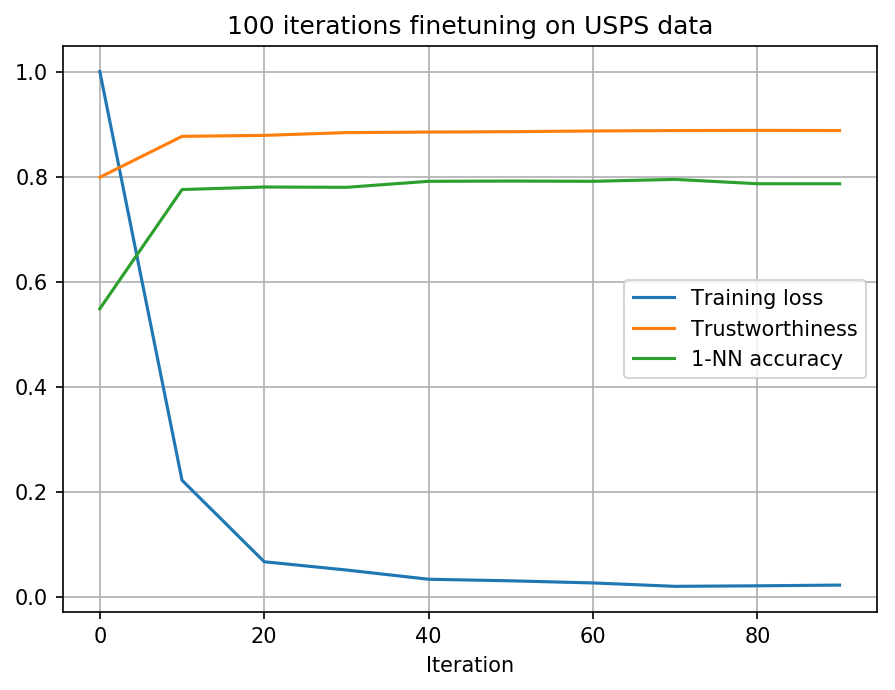

In [19]:
f, axarr = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(7,5), dpi=150)
plt.plot(iterations, loss_score, label='Training loss')
plt.plot(iterations, trust_score, label='Trustworthiness')
plt.plot(iterations, nn_score, label='1-NN accuracy')
plt.grid()
plt.legend()
plt.title('100 iterations finetuning on USPS data')
plt.xlabel('Iteration')